In [1]:
import pandas as pd
import numpy as np
from quantmod.markets import getData
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Loading the data 

In [2]:
df = getData("CRCL", period="5d", interval="1m")
df = df.reset_index()
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df['Datetime']

0      2025-06-17 13:31:00
1      2025-06-17 13:32:00
2      2025-06-17 13:33:00
3      2025-06-17 13:34:00
4      2025-06-17 13:35:00
               ...        
1888   2025-06-24 19:55:00
1889   2025-06-24 19:56:00
1890   2025-06-24 19:57:00
1891   2025-06-24 19:58:00
1892   2025-06-24 19:59:00
Name: Datetime, Length: 1893, dtype: datetime64[ns]

## Step 2: Selecting the Target Day

In [3]:
target_day = "2025-06-24"
day_df = df[df['Datetime'].dt.date == pd.to_datetime(target_day).date()].copy()

day_df.reset_index(drop=True, inplace=True)
day_df

,Datetime,Open,High,Low,Close,Volume
0,2025-06-24 13:30:00,250.419998,253.029999,245.610001,248.600006,8891692
1,2025-06-24 13:32:00,245.744995,251.160004,243.130005,251.126007,1098336
2,2025-06-24 13:33:00,251.149994,254.800003,247.678497,251.779999,560593
3,2025-06-24 13:34:00,251.779999,253.500000,248.000000,249.970001,377044
4,2025-06-24 13:35:00,248.934006,250.000000,244.000000,246.490005,412208
...,...,...,...,...,...,...
374,2025-06-24 19:55:00,224.818802,224.818802,223.300095,224.253494,144035
375,2025-06-24 19:56:00,224.279999,225.330002,224.274994,225.149994,92556
376,2025-06-24 19:57:00,225.240005,225.720001,224.979996,225.330002,122801
377,2025-06-24 19:58:00,225.229996,226.000000,225.190002,225.399994,115713


## Step 3: Calculate the VWAP（Volume Weighted Average Price）

In [4]:
vwap = (day_df['Close'] * day_df['Volume']).sum() / day_df['Volume'].sum()
print (f"The VWAP on {target_day} is {vwap:.4f}")

The VWAP on 2025-06-24 is 241.2810


## Step 4: Calculate TWAP (Time Weighted Average Price)

In [5]:
# Simulated total Order Quantity
total_qty = 10000

# Total minitues within the target day
num_minutes = len(day_df)

# Fixed order quantity per minitues
day_df['TAWP_Order'] =  total_qty / num_minutes

# Order cost per minitues
day_df['TWAP_Cost'] = day_df['TAWP_Order'] * day_df['Close']

# Mean cost of actural cost
twap = day_df['TWAP_Cost'].sum() / total_qty
print (f"The TWAP on {target_day} is {twap:.4f}")

The TWAP on 2025-06-24 is 239.5220


## Step 5: Strategy Simulation

In [6]:
def price_noise(df, volatility=0.01):
    df_noisy = df.copy()
    noise = np.random.normal(loc=0, scale=volatility, size=len(df))
    df_noisy['Close'] = df['Close'] * (1 + noise)
    return df_noisy

In [7]:
def simulate_strategy_execution(df, strategy='twap', total_qty=10000):
    df = df.copy()
    num_minutes = len(df)

    if strategy == 'twap':
        df['Order'] = total_qty / num_minutes
    elif strategy == 'vwap':
        df['Order'] = total_qty * (df['Volume'] / df['Volume'].sum())
    else:
        raise ValueError("Has to be 'twap' or 'vwap'only ")

    df['Cost'] = df['Order'] * df['Close']
    exec_price = df['Cost'].sum() / total_qty
    return exec_price

In [8]:
def monte_carlo(df, strategy='twap', num_simu=1000, volatility=0.01):
    prices = []

    for _ in range(num_simu):
        df_noisy = price_noise(df, volatility=volatility)
        price = simulate_strategy_execution(df_noisy, strategy=strategy)
        prices.append(price)
    return prices

In [9]:
# Simulate results under two strategies
twap_results = monte_carlo(day_df, strategy='twap')
vwap_results = monte_carlo(day_df, strategy='vwap')

# Set VWAP as benchmark  
vwap_benchmark = vwap  

# Calculate Splippage
twap_slippage = np.array(twap_results) - vwap_benchmark
vwap_slippage = np.array(vwap_results) - vwap_benchmark

## Step 6: Visualize Performance

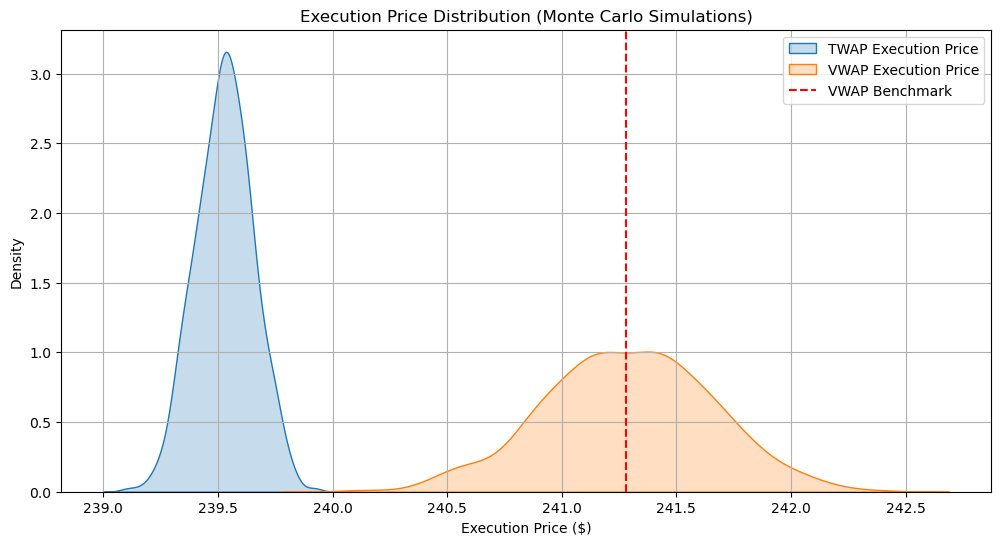

In [10]:
# Execution Price Distribution

plt.figure(figsize=(12,6))
sns.kdeplot(twap_results, label='TWAP Execution Price', fill=True)
sns.kdeplot(vwap_results, label='VWAP Execution Price', fill=True)
plt.axvline(x=vwap, color='red', linestyle='--', label='VWAP Benchmark')
plt.title('Execution Price Distribution (Monte Carlo Simulations)')
plt.xlabel('Execution Price ($)')
plt.legend()
plt.grid(True)
plt.show()

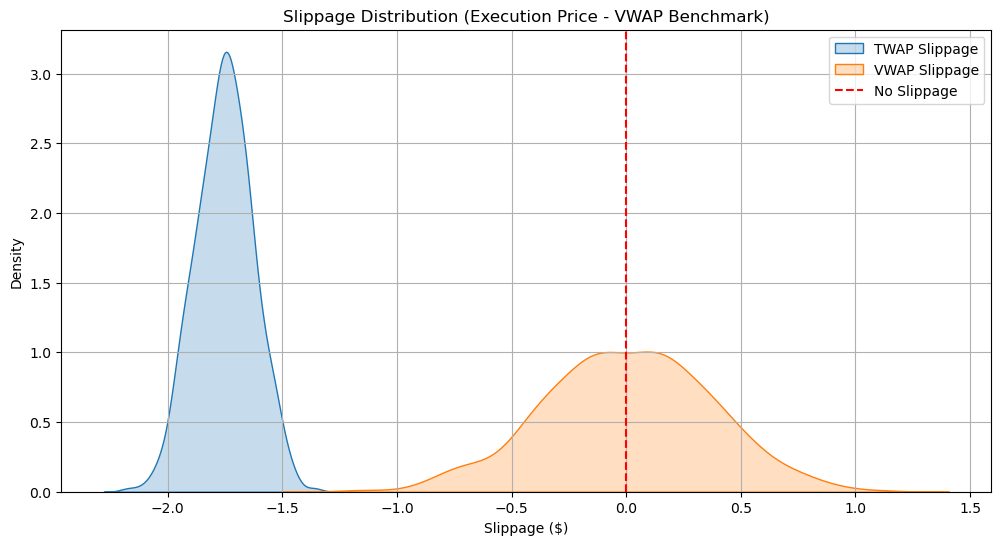

In [11]:
# Slippage Distribution

plt.figure(figsize=(12, 6))
sns.kdeplot(twap_slippage, label='TWAP Slippage', fill=True)
sns.kdeplot(vwap_slippage, label='VWAP Slippage', fill=True)

plt.axvline(0, color='red', linestyle='--', label='No Slippage')
plt.title('Slippage Distribution (Execution Price - VWAP Benchmark)')
plt.xlabel('Slippage ($)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
print("TWAP slippage mean:", np.mean(twap_slippage).round(4))
print("TWAP slippage std:", np.std(twap_slippage).round(4))

print("VWAP slippage mean:", np.mean(vwap_slippage).round(4))
print("VWAP slippage std:", np.std(vwap_slippage).round(4))

TWAP slippage mean: -1.7536
TWAP slippage std: 0.1258
VWAP slippage mean: 0.0059
VWAP slippage std: 0.3661


In [13]:
# Win Ratio 
win_rate = np.mean(np.array(twap_slippage) < np.array(vwap_slippage))
print(f"TWAP has lower slippage than VWAP in {win_rate:.2%} of simulations")

TWAP has lower slippage than VWAP in 100.00% of simulations
